# GATE (Listmode Reconstruction; Without Time of Flight)

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


During this script, some ROOT files generated from gate are saved as .pt tensors throughout the process. Since reading the ROOT files takes considerable time, it is recommended to just open the generated .pt files in subsequent runs of this script:

In [2]:
LOAD_FROM_ROOT = False # Set to true if .pt files not generated

Required data:

In [3]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
# Paths to all ROOT files containing data
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23]) #path 23 corrupted

We can look at the information of our PET scanner:

In [4]:
info

{'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}

## Normalization Correction

In PET imaging, each detector crystal used in the scanner will have a different response to a uniform source due to its positioning (e.g. crystals at the end of edge of modules are different than those in the center). Adequate PET reconstruction takes this into account by first performing a calibration scan for a scanner and obtaining a normalization correction factor for each crystal pair LOR

**The cell below only needs to be ran once**, and may take a long time, as it requires opening and parsing through all the ROOT files corresponding to the normalization scan. Once it is ran, the normalization weights corresponding to each pair of detector IDs will be obtained (due to geometry/crystal orientation).

 This particular calibration scan was done using a thin cylindrical shell. We can compute $\eta$ using a particular function in the gate functionality of PyTomography. Then we save it as a `torch.Tensor` file for easy access in the next part. For this we need

* `cylinder_radius`: The radius of the thin cylindrical shell used for calibration

In [5]:
if LOAD_FROM_ROOT:
    normalization_paths = [os.path.join(path, f'normalization_scan/mMR_Norm_{i}.root') for i in range(1,37)]

    # Get normalization weights for all possible detector ID pairs
    normalization_weights = gate.get_normalization_weights_cylinder_calibration(
        normalization_paths,
        info,
        cylinder_radius = 318, # mm (radius of calibration cylindrical shell,
        include_randoms=False 
    )

    torch.save(normalization_weights, os.path.join(path, 'normalization_weights.pt'))
normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))

## Primary-Only Reconstruction

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data (i.e. we will manually exclude all scatters/randoms). We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [6]:
if LOAD_FROM_ROOT:
    detector_ids = gate.get_detector_ids_from_root(
        paths,
        info,
        include_randoms=False,
        include_scatters=False)
    torch.save(detector_ids, os.path.join(path, 'detector_ids_primary_only.pt'))
detector_ids = torch.load(os.path.join(path, 'detector_ids_primary_only.pt'))

Lets also get the true scatters and randoms from this data so we can compare our estimation later on

In [7]:
if LOAD_FROM_ROOT:
    detector_ids_randoms_true = gate.get_detector_ids_from_root(
        paths,
        info,
        randoms_only=True)
    detector_ids_scatters_true = gate.get_detector_ids_from_root(
        paths,
        info,
        scatters_only=True)
    torch.save(detector_ids_randoms_true, os.path.join(path, 'detector_ids_randoms_true.pt'))
    torch.save(detector_ids_scatters_true, os.path.join(path, 'detector_ids_scatters_true.pt'))
detector_ids_randoms_true = torch.load(os.path.join(path, 'detector_ids_randoms_true.pt'))
detector_ids_scatters_true = torch.load(os.path.join(path, 'detector_ids_scatters_true.pt'))

We reconstruct PET listmode data as follows:
* Note: in this case, our sensitivity weights only have contribution from the normalization factor $\eta$ (and not attenuation $\mu$), so we need to include the attenuation map in the system matrix to get the true sensitivity weights

In [8]:
# Specify object space for reconstruction
# Specify object space for reconstruction
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
# Get projection space metadata from PET geometry information dictionary
proj_meta = PETLMProjMeta(
    detector_ids = detector_ids, # list of all detected event detector ID pairs
    info = info,
    weights_sensitivity=normalization_weights
    )
# Get attenuation map and PSF transform from the associated phantom
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
psf_transform = GaussianFilter(4) # 4mm gaussian blurring
# Create system matrix
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    attenuation_map = atten_map,
    N_splits=8,
)
# Create likelihood. For listmode reconstruction, projections don't need to be provided, since all detection events are stored in proj_meta
likelihood = PoissonLogLikelihood(
    system_matrix
)
# Initialize reconstruction algorithm
recon_algorithm = OSEM(likelihood)
# Reconstruct
recon_primaryonly = recon_algorithm(n_iters=4, n_subsets=14)

Plot the reconstruction of primary only events:

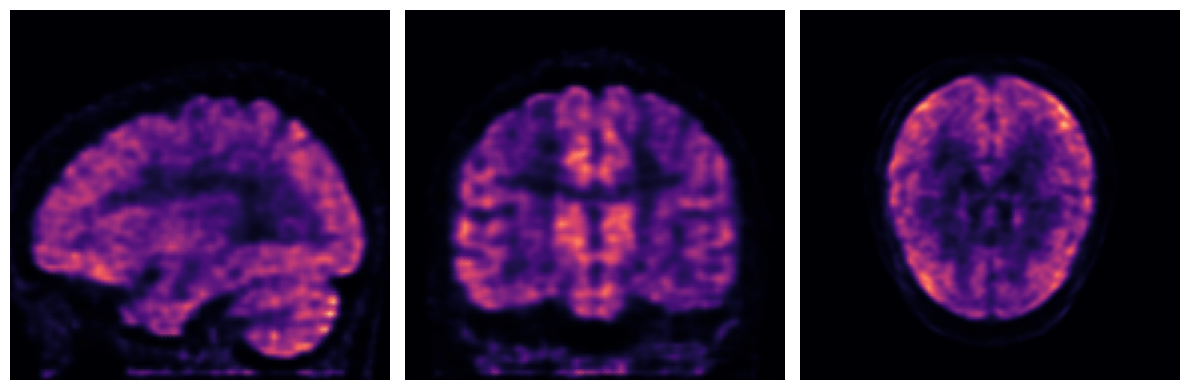

In [9]:
vmax = 0.15
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

## Reconstructing With Random/Scatter Estimation

For reconstruction of all events, we need to estimate boths randoms and scatters. Lets now get **all** events that were obtained in GATE:

In [10]:
if LOAD_FROM_ROOT:
    detector_ids = gate.get_detector_ids_from_root(
        paths,
        info)
    torch.save(detector_ids, os.path.join(path, 'detector_ids_all_events.pt'))
detector_ids = torch.load(os.path.join(path, 'detector_ids_all_events.pt'))

### Randoms

For random estimation via listmode, we

1. Open listmode of all delayed events
2. Convert these to a sinogram
3. Smooth the sinogram
4. Convert back to listmode


In [11]:
if LOAD_FROM_ROOT:
    detector_ids_delays = gate.get_detector_ids_from_root(
        paths,
        info,
        substr = 'delay')
    torch.save(detector_ids_delays, os.path.join(path, 'detector_ids_delays.pt'))
detector_ids_delays= torch.load(os.path.join(path, 'detector_ids_delays.pt'))

In [12]:
sinogram_delays  = gate.listmode_to_sinogram(detector_ids_delays , info)
sinogram_delays  = gate.smooth_randoms_sinogram(sinogram_delays , info, sigma_r=4, sigma_theta=4, sigma_z=4)
lm_delays = shared.sinogram_to_listmode(detector_ids, sinogram_delays , info)

### Scatters

PyTomography estimates scatters via the single scatter simulation (SSS) algorithm (w or w/o time of flight). In order to use SSS, we need an initial reconstruction of the data (without scatter estimation). We use this reconstruction as a proxy to estimate scatter. Let's first reconstruct the data without scatter estimation (but using randoms):

In [13]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))
proj_meta = PETLMProjMeta(
    detector_ids[:,:2],
    info,
    weights_sensitivity=normalization_weights
    )
psf_transform = GaussianFilter(4)
system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       attenuation_map=atten_map.to(pytomography.device),
)

We'll reconstruct only using randoms as an estimate. We need to pass the random listmode weights estimate divided by the sensitivty listmode weights as an additive term estimate to the likelihood function:

In [14]:
# Get additive term (without scatter term):
lm_sensitivity = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_delays / lm_sensitivity
additive_term[additive_term.isnan()] = 0 # remove NaN values
# Recon
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(4,14)

Now we estimate the scatter sinogram as we did before, and then convert to listmode after. Note that we still provide the sinogram of randoms (even though we're reconstructing listmode)

In [15]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = None, # assumes listmode
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_delays
    )
# Now convert to listmode
lm_scatter = shared.sinogram_to_listmode(proj_meta.detector_ids, sinogram_scatter, proj_meta.info)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we can redefine our additive term to include scatter information and reconstruct:

In [16]:
additive_term = (lm_scatter + lm_delays) / lm_sensitivity
additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_lm_nontof = recon_algorithm(4,14)

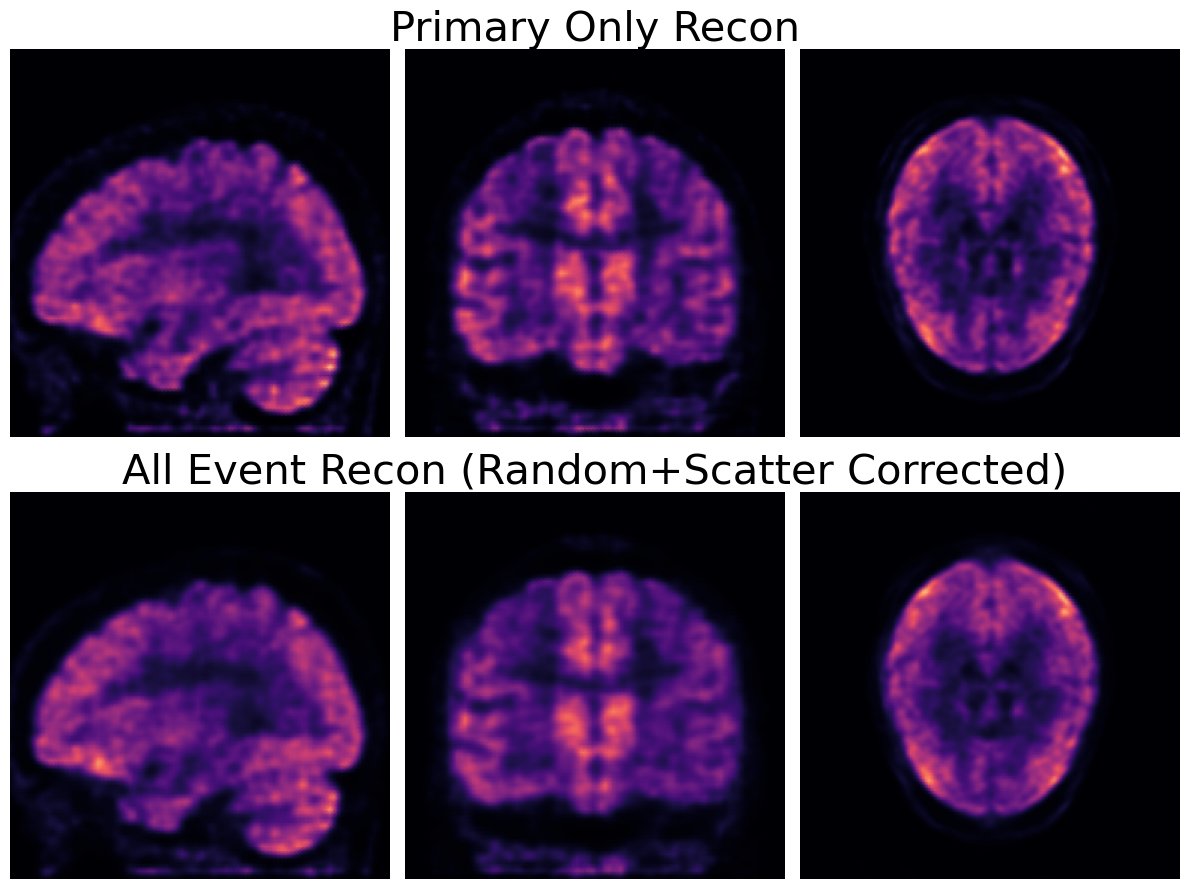

In [17]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_lm_nontof[48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_lm_nontof[16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_lm_nontof[:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
fig.tight_layout()
plt.show()